<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Ресемплирование-данных" data-toc-modified-id="Ресемплирование-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Разложение-временного-ряда" data-toc-modified-id="Разложение-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разложение временного ряда</a></span></li><li><span><a href="#Создание-признаков-для-обучения-моделей" data-toc-modified-id="Создание-признаков-для-обучения-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков для обучения моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-парметров-max_lag-и-rolling_mean_size" data-toc-modified-id="Подбор-парметров-max_lag-и-rolling_mean_size-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подбор парметров <code>max_lag</code> и <code>rolling_mean_size</code></a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Библиотека-градиентного-бустинга-LightGBM" data-toc-modified-id="Библиотека-градиентного-бустинга-LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Библиотека градиентного бустинга LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Загрузка и подготовка данных

In [16]:
# Загрузим необходимые для работы библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
#from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import time

In [2]:
# Считаем данные
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Проврим наличие пропусков
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
# Отсортируем данные в хронологическом порядке
data.sort_index(inplace=True)
print(data.index.is_monotonic)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


### Ресемплирование данных

Произведем ресемплирование данных с интервалом 1 час, так как именно этот интервал интересует заказчика

In [6]:
data = data.resample('1H').sum()

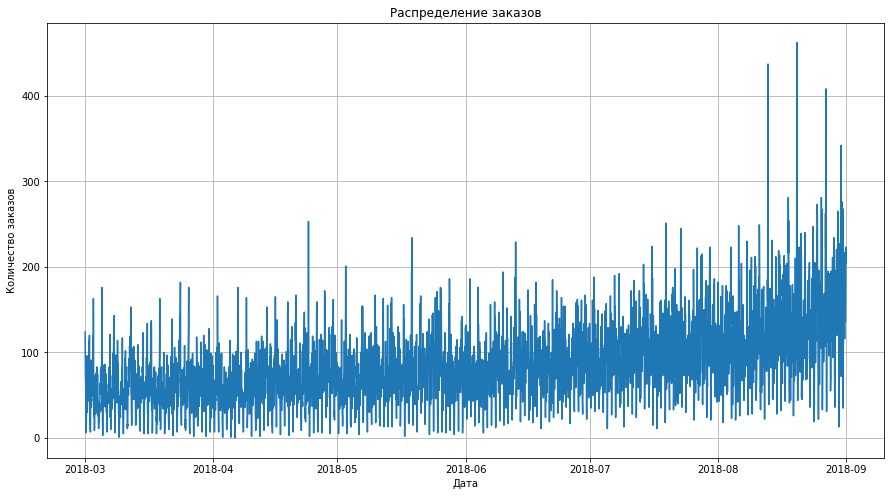

In [7]:
# Построим график временного ряда
plt.figure(figsize=(15, 8))
plt.plot(data)
plt.title("Распределение заказов")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.grid()
plt.show()

# Вывод
 - Данные открыты с распознаванием дат и формированием новых индексов
 - Поизведена сортировка данных хронологическом порядке
 - Произведён ресемплинг по суммарным значениям за час

## Анализ

### Разложение временного ряда

Разложим временной ряд на тренд и сезонную компоненту

In [8]:
decomposed = seasonal_decompose(data)

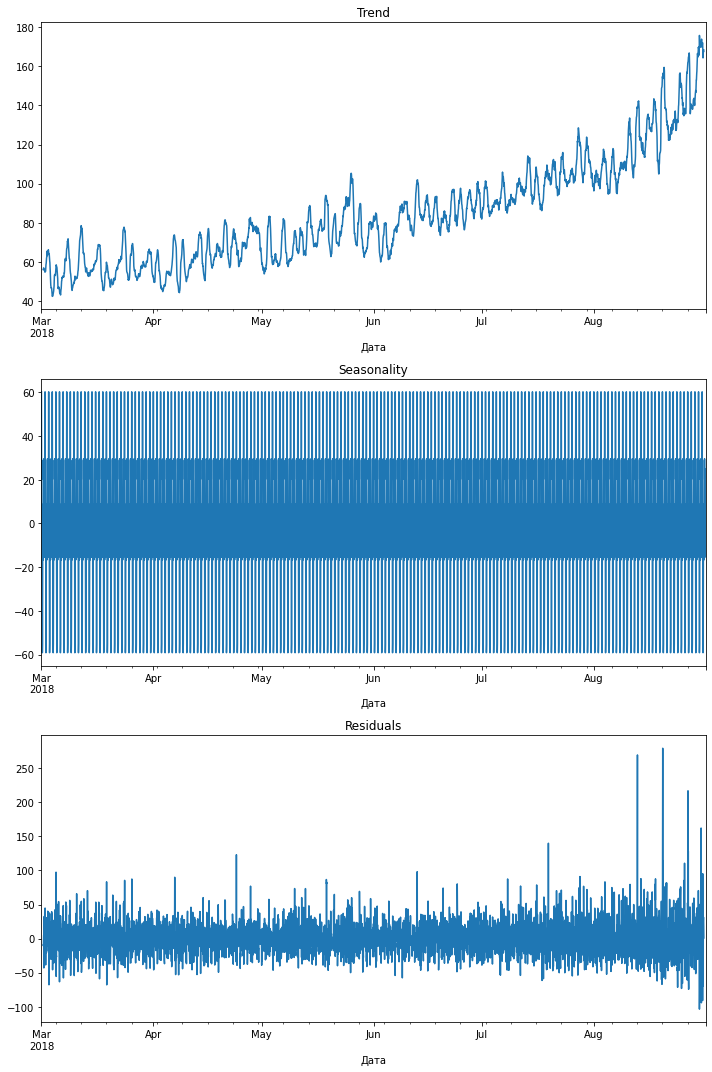

In [9]:
plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel("Дата")
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel("Дата")
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.xlabel("Дата")
plt.tight_layout()

***Первое, что мы видим - восходящий тренд, количество заказов у фирмы постепенно увеличивается***

Построим график сезонной составляющей за август

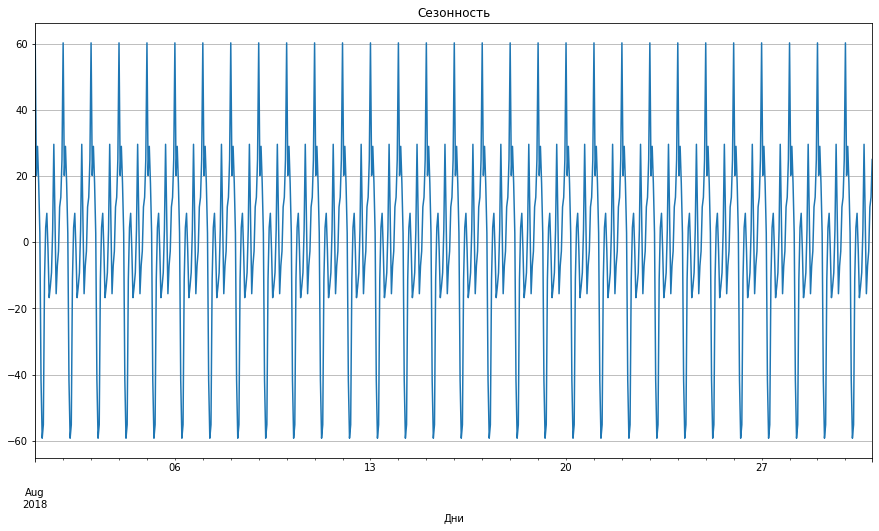

In [10]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-08-01':'2018-08-30'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дни")
plt.grid(True)
plt.show()

Построим сезонный график для 1 недели (6.08.2018 - 12.08.2018)

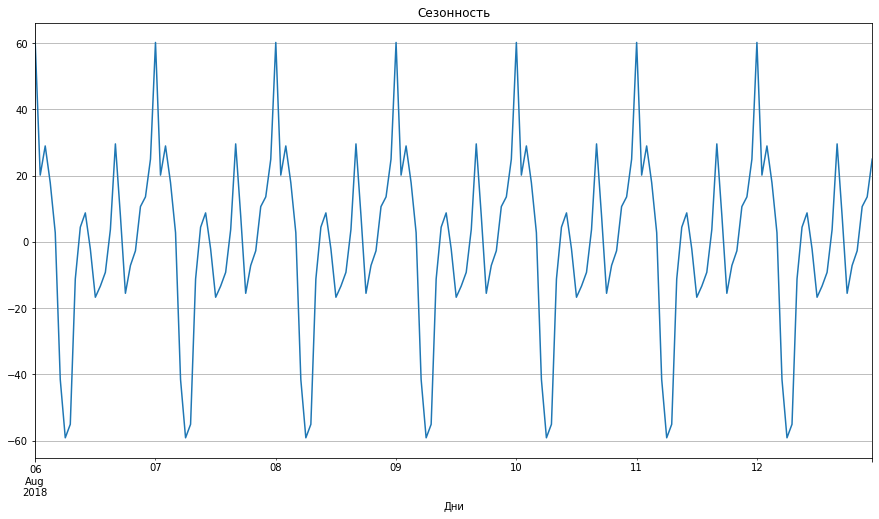

In [11]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дни")
plt.grid(True)
plt.show()

Построим график сезонности для даты 06.08.2018

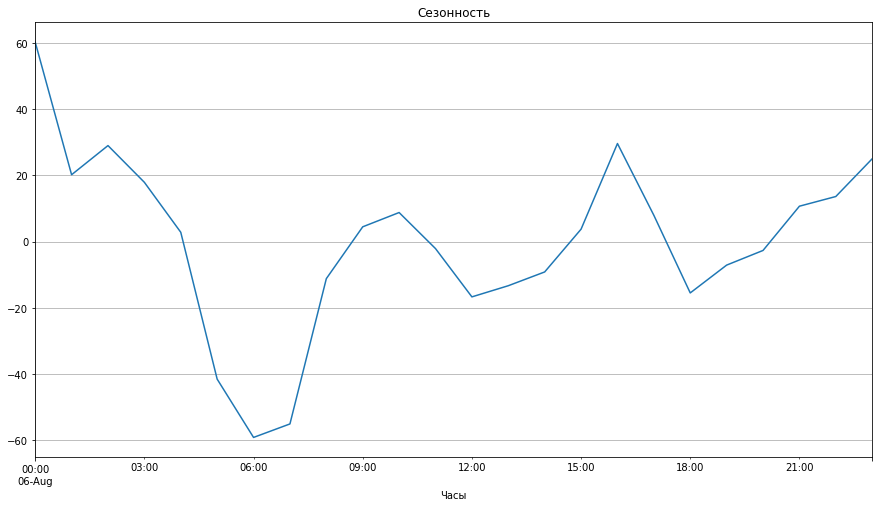

In [12]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-08-06':'2018-08-06'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Часы")
plt.grid(True)
plt.show()

Мы видим, что пик заказов приходится на 12 часов ночи, а минимальное количество заказов в 6 утра

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

### Создание признаков для обучения моделей

Напишим функцию `make_features()`, чтобы прибавить к таблице 2 новых календарных признака: час, день. Имена столбцов должны быть такие: `'day'`, `'hour'`. Месяц учитывать как признак не будем, так как у нас данные всего за один год - а это слишком мало, чтобы понять как зависит количество заказов от месяца. Так же в функцию `make_features()` добавим аргумент `ax_lag`, который задаст максимальный размер отставания и скользящее среднее `rolling_mean`

In [13]:
data_new = data.copy()
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

Напишем функцию, которая разделит нашу выборку на тренировочную и тестовую

In [14]:
def train_test (data):
    train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state = 12345)
    train = train.dropna()

    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test= test['num_orders']
    return features_train, target_train, features_test, target_test

### Вывод

 - Наблюдается общий тренд к росту заказов
 - Наблюдается повышение количества заказов в 12 часов ночи, минимум заказов наюлюдается в 6 утра
 - Созданы дополнительные признаки из разбиения дат, "отстающих значений", и скользящего среднего
 - Создана функция для разделения дат на обучающую и тестовую выборку

## Обучение

### Подбор парметров `max_lag` и `rolling_mean_size`

Используя модель `LinearRegression` подюерем оптимальные значения параметров `max_lag` и `rolling_mean_size`

In [19]:
max_lag_train = [5,10,15,20]
rolling_size_train = [10,15,20]
lag = max_lag_train[0]
rolling = rolling_size_train[0]
error = 1000000
for i in max_lag_train:
    for j in rolling_size_train: 
        make_features(data, i, j)
        features_train, target_train, features_test, target_test = train_test(data)
        tscv = TimeSeriesSplit(n_splits=5)
        model = LinearRegression(normalize=True)
        rmse_model = cross_val_score(model, features_train, target_train, cv=tscv, scoring = 'neg_mean_squared_error')
        error_ed=((rmse_model*-1)**0.5).mean()
        
        data = data_new.copy()
        if error_ed < error:
            lag=i
            rolling = j
            error = error_ed
    data = data_new.copy()

In [20]:
print('max_lag=', lag)
print('rolling_mean_size = ', rolling)

max_lag= 20
rolling_mean_size =  10


Мы нашли оптимальные параметры `max_lag` и `rolling_mean_size`, передадим их в наш датасет и разобьем данные на тренировочную и тестовую выборки

In [21]:
make_features(data, 20, 10)
features_train, target_train, features_test, target_test = train_test(data)

In [22]:
del data_new

### Линейная регрессия

In [23]:
%%time

model_lr = LinearRegression(normalize=True)

rmse_lr = cross_val_score(model_lr, features_train, target_train, cv=tscv, scoring = 'neg_mean_squared_error')
rmse_lr_best=((rmse_lr*-1)**0.5).mean()
rmse_lr_best

CPU times: user 236 ms, sys: 304 ms, total: 540 ms
Wall time: 477 ms


32.24487579870505

### Случайный лес

In [24]:
%%time
model_rf =  RandomForestRegressor(random_state=12345)
grid = {'n_estimators':[10,20,30,40,50],
        'max_depth': [5,6,7,8,9,10]}
rf = GridSearchCV(model_rf, grid,cv=, scoring='neg_mean_squared_error')
rf.fit(features_train, target_train)
rmse_rf_best = ((rf.best_score_)*-1)**0.5

CPU times: user 56.6 s, sys: 316 ms, total: 56.9 s
Wall time: 57 s


In [25]:
rmse_rf_best

26.19953640882862

### CatBoost

In [26]:
%%time

train_dataset = Pool(features_train, target_train) 
test_dataset = Pool(features_test, target_test)
model_cat = CatBoostRegressor(random_state = 12345, verbose=False)
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.3, 0.4, 0.5],
        'depth': [2, 4, 6, 8]}
model_cat_boost=GridSearchCV(model_cat, grid, scoring='neg_mean_squared_error', cv=tscv)
model_cat_boost.fit(features_train, target_train)

CPU times: user 1min 58s, sys: 2.84 s, total: 2min 1s
Wall time: 3min 18s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5d907c2c40>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [100, 150, 200],
                         'learning_rate': [0.3, 0.4, 0.5]},
             scoring='neg_mean_squared_error')

In [27]:
cat_score=((model_cat_boost.best_score_)*-1)**0.5
cat_score

25.933156726612545

In [28]:
model_cat_boost.best_params_

{'depth': 4, 'iterations': 150, 'learning_rate': 0.3}

### Библиотека градиентного бустинга LightGBM

In [29]:
%%time
regressor = LGBMRegressor(n_estimators=50) 
grid = {'num_leaves':[11, 50],
        'learning_rate': [0.3, 0.4]}
model_lgbm = GridSearchCV(regressor, grid, scoring='neg_mean_squared_error', verbose=10, cv=tscv)
model_lgbm.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 1/5; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   0.1s
[CV 2/5; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 2/5; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   0.2s
[CV 3/5; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 3/5; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   0.2s
[CV 4/5; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 4/5; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   0.3s
[CV 5/5; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 5/5; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   0.3s
[CV 1/5; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 1/5; 2/4] END ..........learning_rate=0.3, nu

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_estimators=50),
             param_grid={'learning_rate': [0.3, 0.4], 'num_leaves': [11, 50]},
             scoring='neg_mean_squared_error', verbose=10)

In [26]:
rmse_lgbm_best = ((model_lgbm.best_score_)*-1)**0.5
rmse_lgbm_best

26.199787021212657

In [33]:
model_lgbm.best_params_

{'learning_rate': 0.3, 'num_leaves': 11}

### Вывод
Мы обучили 4 модели:
  - Линейгая регрессия
  - Случайный лес
  - CatBoost
  - Библиотека градиентного бустинга LightGBM
  
  Лeчший результат показала мдель `CatBoost` RMSE= 19.81

## Тестирование

Протестируем лучшую мождель на тестовых данных


In [30]:
model_cat_best = CatBoostRegressor(random_state = 12345, iterations =150, learning_rate = 0.3, depth =4,  verbose=False)
model_cat_best.fit(features_train, target_train)
predict = model_cat_best.predict(features_test)

In [31]:
cat_test_rmse = (mean_squared_error(target_test, predict))** 0.5 
cat_test_rmse

45.82646612722588

<AxesSubplot:xlabel='datetime'>

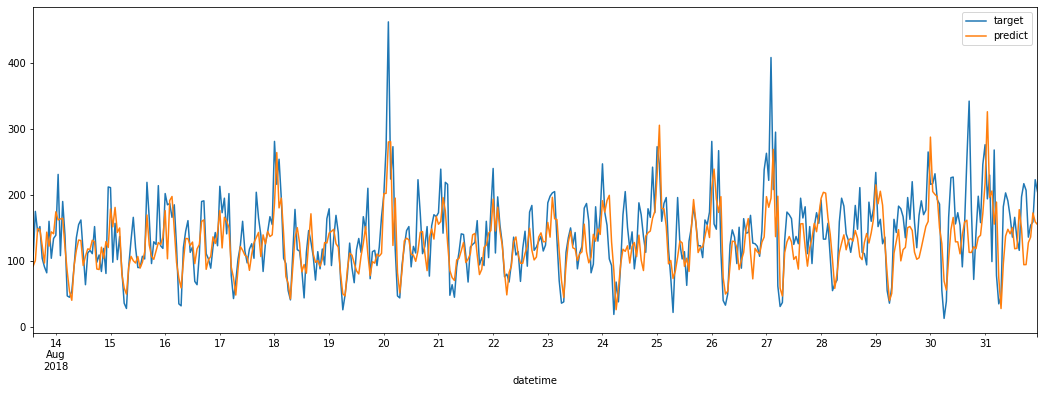

In [32]:
#Построим график исходных и предсказанных значений
model_data = pd.DataFrame({"target":target_test, "predict":predict})
model_data.plot(figsize=(18, 6))


RMSE на тестовой выборке получился равен 45,83, чт осоответствует условиям задачи

Провеим модель на адекватность, найдем RMSE модели, которая всегда предсказывает средние значения

In [42]:
dummy_regr = DummyRegressor(strategy ="mean")
dummy_regr.fit(features_train, target_train)
dummy_predict = dummy_regr.predict(features_test)
dummy_test_rmse = (mean_squared_error(target_test, dummy_predict))** 0.5 
dummy_test_rmse

84.6528030070785

RMSE константной модели больше ,чем RMSE нашей лучшей модели, значит проверка на адекватность пройдена

# Общий вывод

    В ходе исследования выполены следующие действия:

     - Данные получены, открыты с распознаванием дат и формированием новых индексов
     - Поизведена сортировка данных в порядке хронологическом порядке
     - Произведён ресемплинг по суммарным значениям за час
     - Созданы дополнительные признаки из разбиения дат, "отстающих значений", и скользящего среднего
     - Данные подготовлены для обучения моделей
     - Обучены 4 модели:
         - Линейгая регрессия
         - Случайный лес
         - CatBoost
         - Библиотека градиентного бустинга LightGBM

    Для тестирования выбрана модель CatBoostRegressor, которая показала лучшие значения RMSE на тренировочных данных

Выбранная модель с рассчитаными параметрами на тестовой выборке получила хороший результат RMSE, удовлетворяющий условиям задачи: 44.82 < 48

Проверка на адекватность показала, что точность выбранной модели выше модели, предсказывающей только средние значения.